### Imports

In [1]:
import pandas
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import matthews_corrcoef, roc_auc_score, roc_curve, auc
from sklearn.cross_validation import cross_val_score
%matplotlib inline

### Functions 

In [2]:
def mcc(tp, tn, fp, fn):
    sup = tp * tn - fp * fn
    inf = (tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)
    if inf==0:
        return 0
    else:
        return sup / np.sqrt(inf)

In [3]:
def eval_mcc(y_true, y_prob, show=False):
    idx = np.argsort(y_prob)
    y_true_sort = y_true[idx]
    n = y_true.shape[0]
    nump = 1.0 * np.sum(y_true) # number of positive
    numn = n - nump # number of negative
    tp = nump
    tn = 0.0
    fp = numn
    fn = 0.0
    best_mcc = 0.0
    best_id = -1
    prev_proba = -1
    best_proba = -1
    mccs = np.zeros(n)
    for i in range(n):
        # all items with idx < i are predicted negative while others are predicted positive
        # only evaluate mcc when probability changes
        proba = y_prob[idx[i]]
        if proba != prev_proba:
            prev_proba = proba
            new_mcc = mcc(tp, tn, fp, fn)
            if new_mcc >= best_mcc:
                best_mcc = new_mcc
                best_id = i
                best_proba = proba
        mccs[i] = new_mcc
        if y_true_sort[i] == 1:
            tp -= 1.0
            fn += 1.0
        else:
            fp -= 1.0
            tn += 1.0
    if show:
        y_pred = (y_prob >= best_proba).astype(int)
        score = matthews_corrcoef(y_true, y_pred)
        print(score, best_mcc)
        plt.plot(mccs)
        return best_proba, best_mcc, y_pred
    else:
        return best_mcc

In [4]:
def roundn(y_pred, scale):
    return np.around(y_pred * scale) / scale

In [35]:
def mcc_eval(y_prob, dtrain):
    y_true = dtrain.get_label()
    best_mcc = eval_mcc(y_true, roundn(y_prob, 100))
    return 'MCC', 1-best_mcc

### XVal

In [6]:
dtrain = xgb.DMatrix('/home/ubuntu/upload/train.svm')

In [7]:
y=dtrain.get_label()
prior=y.sum()/len(y)

In [56]:
params={}
params['bst:eta'] = 0.1
params['bst:max_depth'] = 4
params['min_child_weight'] = 14
params['objective'] = 'binary:logistic'
params['nthread'] = 4
params['eval_metric'] = 'auc'
params['learning_rate'] = 0.1
params['base_score'] = prior

In [ ]:
with open('log.txt', 'w') as file:
    for max_depth in range(2,5):
        for learning_rate in [0.1, 0.5, 1]:
            for min_child_weight in [14, 16, 18]:
                params['bst:max_depth'] = max_depth
                params['min_child_weight'] = min_child_weight
                params['learning_rate'] = learning_rate
                res = xgb.cv(params, dtrain, num_boost_round=40, feval=mcc_eval, verbose_eval=True, nfold=4, seed=0, early_stopping_rounds=10, show_stdv=True)
                print(repr(res))
                file.write(repr(res))

[0]	train-MCC:0.853637+0.00160432	test-MCC:0.854181+0.00439284
[1]	train-MCC:0.82917+0.00994869	test-MCC:0.829074+0.00938408


### Validation

In [9]:
dtrain_val = xgb.DMatrix('/home/ubuntu/upload/train1.svm')
dval = xgb.DMatrix('/home/ubuntu/upload/train2.svm')

In [54]:
num_round = 40
evallist  = [(dval,'eval')]
bst = xgb.train( params, dtrain_val, num_round, evallist, feval=mcc_eval)

[0]	eval-MCC:0.851877
[1]	eval-MCC:0.875955
[2]	eval-MCC:0.946891
[3]	eval-MCC:0.958033
[4]	eval-MCC:0.966696
[5]	eval-MCC:0.853496
[6]	eval-MCC:0.947909
[7]	eval-MCC:0.951555


KeyboardInterrupt: 

0.205695388703 0.205695388703


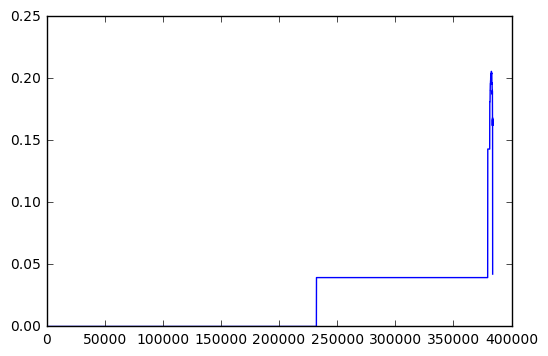

In [51]:
best_proba_val, best_mcc_val, y_pred_val = eval_mcc(dval.get_label(), roundn(bst.predict(dval), 100), show=True)

Feature importance

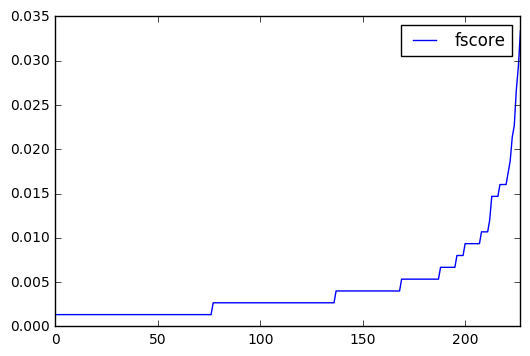

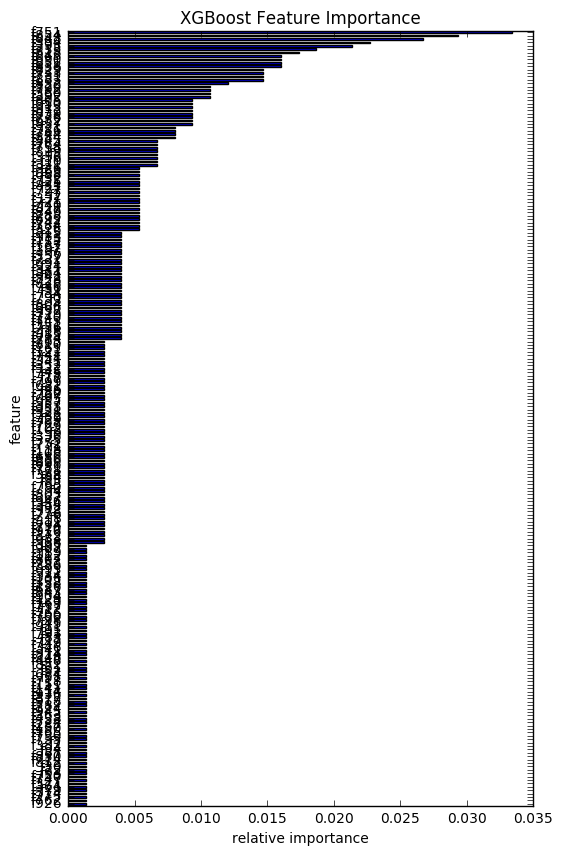

In [18]:
import operator

importance = bst.get_fscore()
importance = sorted(importance.items(), key=operator.itemgetter(1))

df = pandas.DataFrame(importance, columns=['feature', 'fscore'])
df['fscore'] = df['fscore'] / df['fscore'].sum()

plt.figure()
df.plot()
df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')

Check ratio of positive in predictions

In [31]:
y_pred_val.sum()/y_pred_val.size

0.0027648424613091437

Check ration of positive in true labels

In [32]:
label=dval.get_label()
label.sum()/label.size

0.0058163321146484535

In [33]:
best_proba_val

0.14

### Test

In [34]:
num_round=40
bst = xgb.train( params, dtrain, num_round)

In [36]:
dtest = xgb.DMatrix('/home/ubuntu/upload/test.svm')

In [37]:
y_pred_test=roundn(bst.predict(dtest), 100)

In [38]:
results=(y_pred_test >= best_proba_val).astype(int)

In [39]:
results.sum()/results.size

0.0027091914833224638

In [40]:
IDs=pandas.read_csv('/home/ubuntu/upload/Ids.txt')

In [41]:
IDs['Response']=results

In [42]:
IDs.head()

,Id,Response
0,1,0
1,2,0
2,3,0
3,5,0
4,8,0


In [43]:
IDs.to_csv('results.csv', index=False)